<a href="https://colab.research.google.com/github/sriyamistry0-lang/GenTen/blob/main/scRNA_based_Sepsis_Predictor_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scanpy python-igraph louvain leidenalg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 45.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of louvain to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 92.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 102.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 95.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 65.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install scanpy pandas numpy matplotlib

In [7]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. SETTINGS & INPUT ---
prefix = input("Enter Sample Prefix (e.g., GSE245131_39_): ").strip()
matrix_file, features_file, barcodes_file = f"{prefix}matrix.mtx.gz", f"{prefix}features.tsv.gz", f"{prefix}barcodes.tsv.gz"

try:
    # --- 2. LOAD & PREPROCESS ---
    adata = sc.read_mtx(matrix_file).T
    genes = pd.read_csv(features_file, header=None, sep='\t')
    barcodes = pd.read_csv(barcodes_file, header=None, sep='\t')

    if len(genes) != adata.n_vars:
        genes = genes.iloc[:adata.n_vars, :]

    adata.var_names = genes[1].values if genes.shape[1] >= 2 else genes[0].values
    adata.obs_names = barcodes[0].values
    adata.var_names_make_unique()

    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.raw = adata

    sc.pp.highly_variable_genes(adata, n_top_genes=2000)
    adata = adata[:, adata.var.highly_variable].copy()

    # --- 3. DIMENSIONS & TRAJECTORY ---
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
    sc.tl.umap(adata)

    # Scoring
    danger = ['S100A10', 'S100A11', 'S100A4', 'ANXA1', 'FXYD5']
    protective = ['HLA-DRA', 'HLA-DRB1', 'CD74', 'HLA-DPA1', 'HLA-DPB1', 'CD83']
    d_found = [g for g in danger if g in adata.raw.var_names]
    p_found = [g for g in protective if g in adata.raw.var_names]

    sc.tl.score_genes(adata, d_found, score_name='danger_score', use_raw=True)
    sc.tl.score_genes(adata, p_found, score_name='protective_score', use_raw=True)
    adata.obs['sepsis_risk_index'] = adata.obs['danger_score'] - adata.obs['protective_score']

    adata.uns['iroot'] = np.argmin(adata.obs['sepsis_risk_index'])
    sc.tl.diffmap(adata)
    sc.tl.dpt(adata)

    # --- 4. LEGEND & STATE CATEGORIES ---
    conditions = [
        (adata.obs['dpt_pseudotime'] <= 0.2),
        (adata.obs['dpt_pseudotime'] > 0.2) & (adata.obs['sepsis_risk_index'] <= adata.obs['sepsis_risk_index'].median()),
        (adata.obs['sepsis_risk_index'] > adata.obs['sepsis_risk_index'].median())
    ]
    choices = ['Healthy Cells', 'Infected (Transition)', 'Sepsis (Danger Zone)']
    adata.obs['Disease Progression'] = np.select(conditions, choices, default='Infected (Transition)')
    adata.obs['Disease Progression'] = adata.obs['Disease Progression'].astype('category')

    # Set standard colors
    adata.obs['Disease Progression'] = adata.obs['Disease Progression'].cat.reorder_categories(['Healthy Cells', 'Infected (Transition)', 'Sepsis (Danger Zone)'])
    adata.uns['Disease Progression_colors'] = ['#2ca02c', '#1f77b4', '#d62728']

    # --- 5. PLOTTING WITH AXES ---
    # We define the list of maps: Category, Risk, TFs, and Key Genes
    tfs = ['NFKB1', 'IRF1']
    key_markers = ['S100A10', 'HLA-DRA']
    found_plots = ['Disease Progression', 'sepsis_risk_index'] + [g for g in tfs+key_markers if g in adata.raw.var_names]

    print(f"\n🎨 Generating Dashboard with Axes for {prefix}...")

    sc.pl.umap(adata,
               color=found_plots,
               ncols=2,
               cmap='RdYlBu_r',
               legend_loc='right margin',
               frameon=True,        # <--- AXES ARE TURNED ON
               size=25,
               wspace=0.5,
               hspace=0.4)

except Exception as e:
    print(f"❌ Error: {e}")

Enter Sample Prefix (e.g., GSE245131_39_): GSE245131_39
❌ Error: [Errno 2] No such file or directory: 'GSE245131_39matrix.mtx.gz'


In [4]:
!pip install scanpy
import scanpy as sc
import pandas as pd
import numpy as np
import os
import gc # This is the Garbage Collector to save your memory

In [5]:
!pip install leidenalg

In [8]:
!pip install scanpy
import scanpy as sc
import pandas as pd
import numpy as np
import os
import gc

def download_patient_data(patient_id):
    """Surgically downloads only the necessary files for the specific patient."""
    base_url = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE245nnn/GSE245131/suppl/"
    files = ["matrix.mtx.gz", "features.tsv.gz", "barcodes.tsv.gz"]
    for f in files:
        file_name = f"GSE245131_{patient_id}{f}"
        if not os.path.exists(file_name):
            print(f"📥 Downloading {file_name}...")
            os.system(f"wget -q {base_url}{file_name}")
    return f"GSE245131_{patient_id}"

In [18]:
import os
import tarfile
import glob
import gc

def prepare_all_data():
    tar_file = "GSE245131_RAW.tar"
    if not os.path.exists(tar_file):
        print("📥 Downloading full bundle (265MB)...")
        os.system(f"wget -q https://ftp.ncbi.nlm.nih.gov/geo/series/GSE245nnn/GSE245131/suppl/{tar_file}")

    # Check if we've already unpacked to save time
    if not os.path.exists("GSE245131_39matrix.mtx.gz"):
        print("🔓 Unpacking...")
        with tarfile.open(tar_file) as tar:
            tar.extractall()
    print("✅ System Ready.")

prepare_all_data()

✅ System Ready.


Enter Patient IDs to analyze (e.g., 39, 40): 39

🩺 ANALYZING PATIENT CASE: 39
📊 Rendering Dashboard for Patient 39...


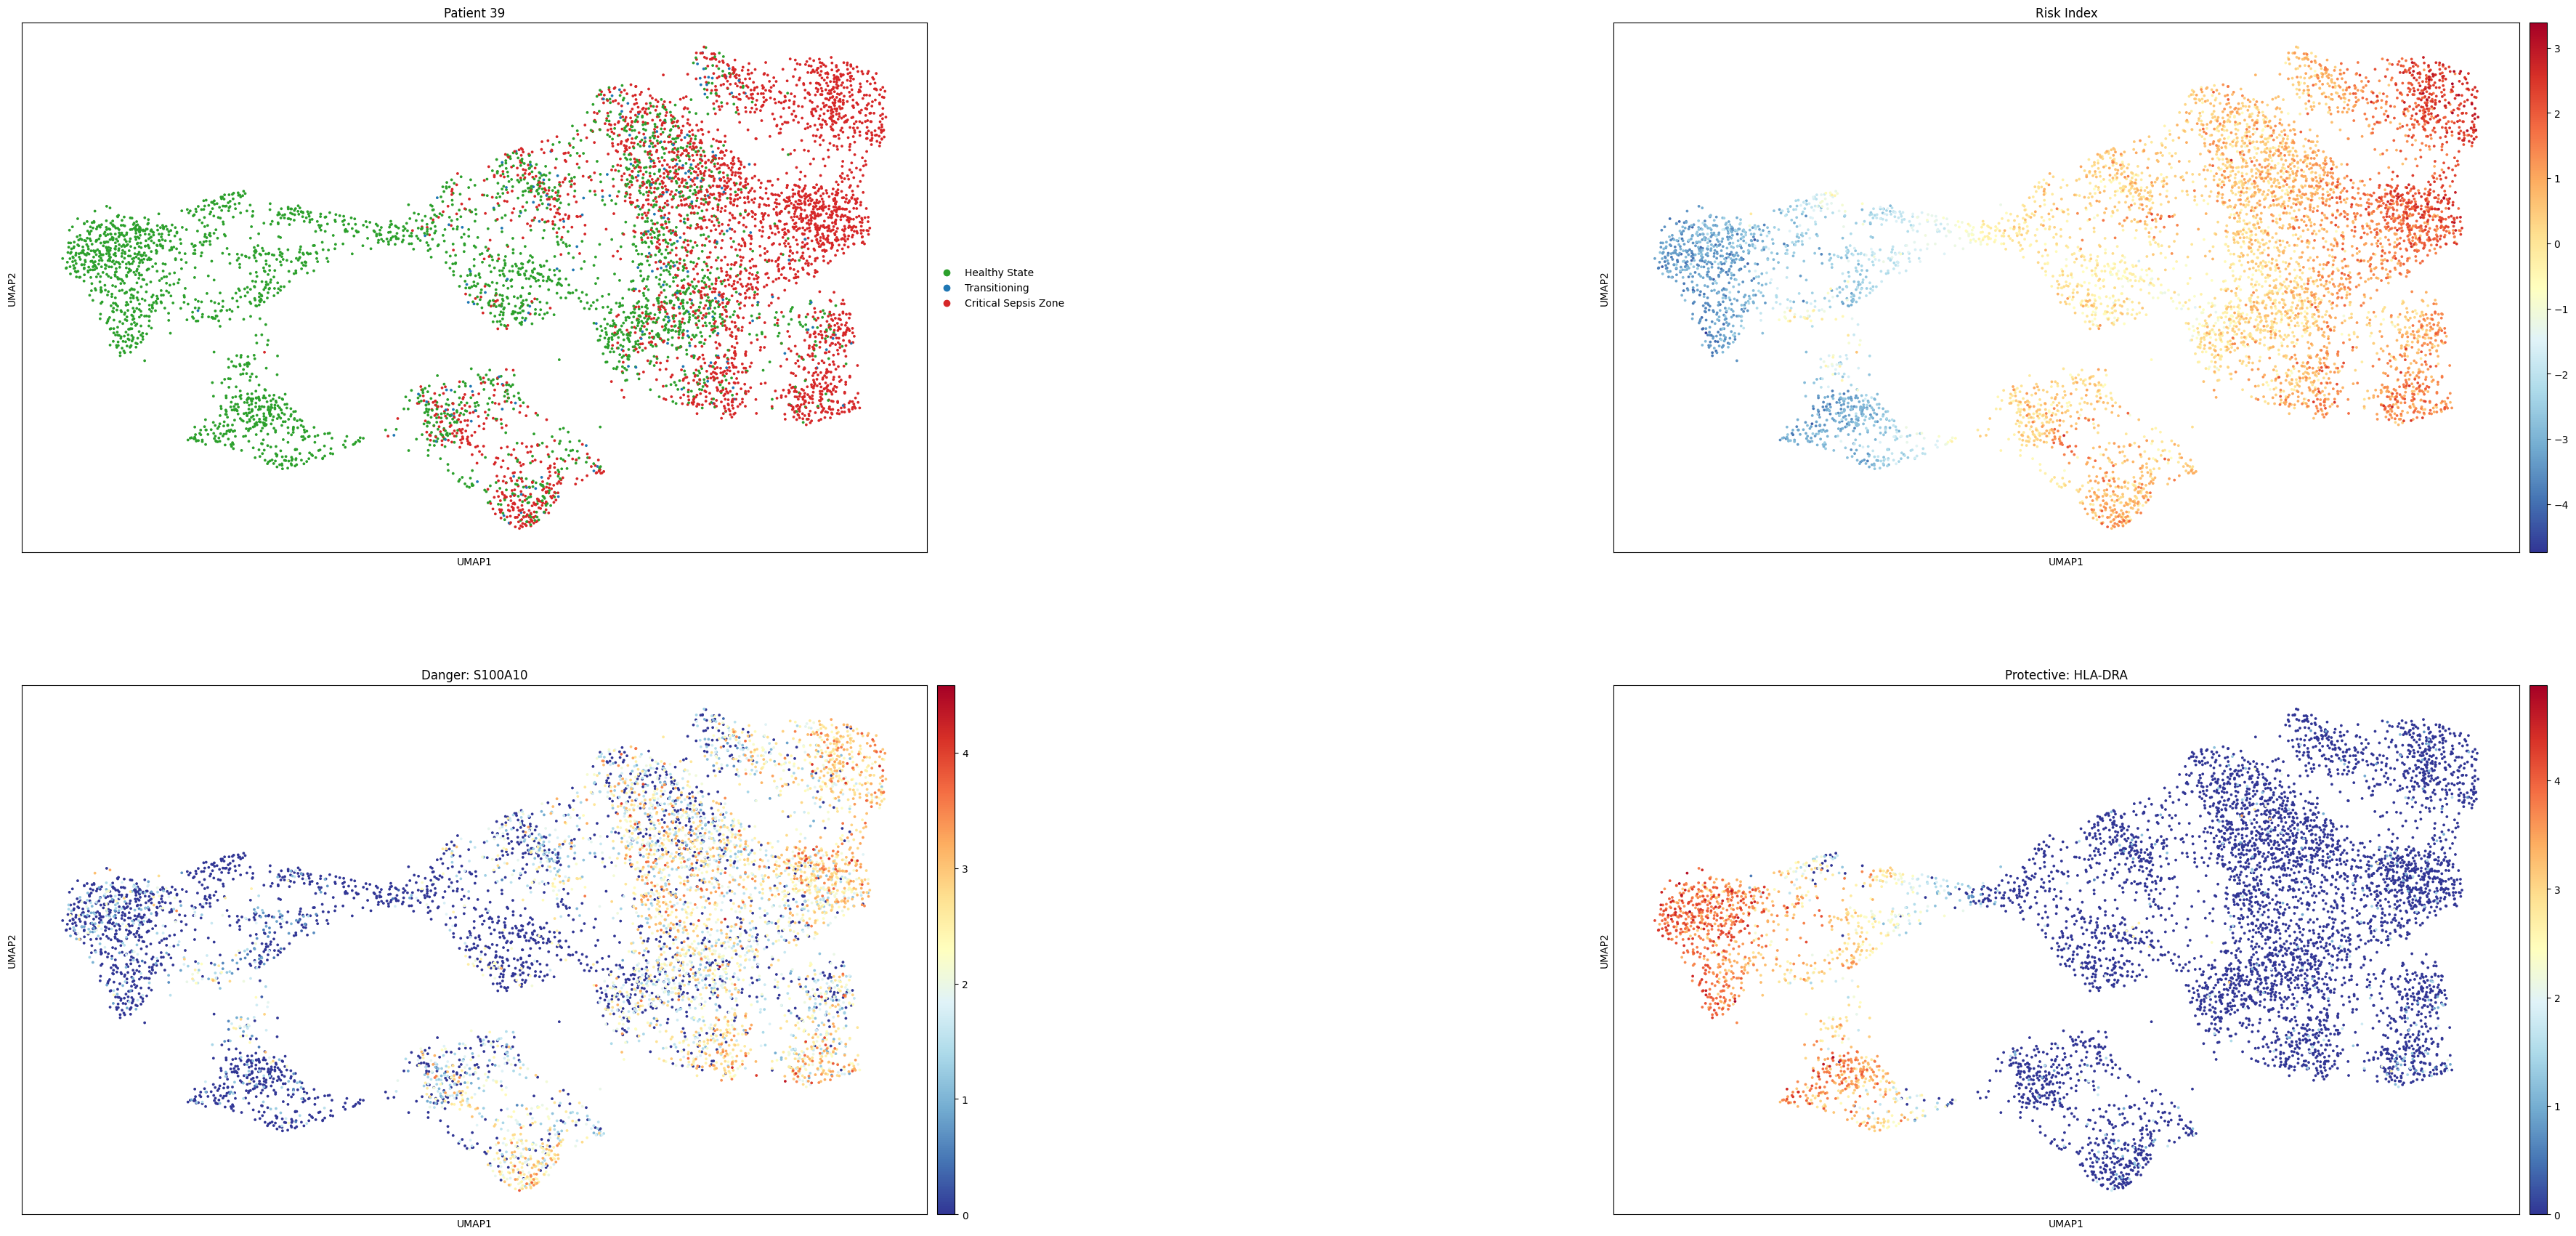

✅ Patient 39 Analysis Complete.


In [23]:
# --- 1. PATIENT ADMISSION ---
user_input = input("Enter Patient IDs to analyze (e.g., 39, 40): ")
patient_list = [p.strip() for p in user_input.split(',')]

for p_id in patient_list:
    print(f"\n" + "="*40)
    print(f"🩺 ANALYZING PATIENT CASE: {p_id}")
    print("="*40)

    prefix = get_prefix(p_id)

    try:
        # --- 2. LOAD DATA ---
        adata = sc.read_mtx(f"{prefix}matrix.mtx.gz").T
        genes = pd.read_csv(f"{prefix}features.tsv.gz", header=None, sep='\t')
        barcodes = pd.read_csv(f"{prefix}barcodes.tsv.gz", header=None, sep='\t')

        adata.var_names = genes[1].values if genes.shape[1] >= 2 else genes[0].values
        adata.obs_names = barcodes[0].values
        adata.var_names_make_unique()

        # --- 3. QC & SCORING ---
        sc.pp.filter_cells(adata, min_genes=200)
        sc.pp.filter_genes(adata, min_cells=3)
        sc.pp.normalize_total(adata, target_sum=1e4)
        sc.pp.log1p(adata)
        adata.raw = adata

        danger = ['S100A10', 'S100A11', 'S100A4', 'ANXA1', 'FXYD5']
        protective = ['HLA-DRA', 'HLA-DRB1', 'CD74', 'HLA-DPA1', 'HLA-DPB1', 'CD83']
        d_found = [g for g in danger if g in adata.raw.var_names]
        p_found = [g for g in protective if g in adata.raw.var_names]

        sc.tl.score_genes(adata, d_found, score_name='danger_score', use_raw=True)
        sc.tl.score_genes(adata, p_found, score_name='protective_score', use_raw=True)
        adata.obs['sepsis_risk_index'] = adata.obs['danger_score'] - adata.obs['protective_score']

        # --- 4. UMAP (Memory Optimized) ---
        sc.pp.highly_variable_genes(adata, n_top_genes=2000)
        adata_sub = adata[:, adata.var.highly_variable].copy()
        sc.tl.pca(adata_sub, svd_solver='arpack')
        sc.pp.neighbors(adata_sub, n_neighbors=15, n_pcs=30)
        sc.tl.umap(adata_sub)
        adata.obsm['X_umap'] = adata_sub.obsm['X_umap']
        del adata_sub # Clear memory

        # --- 5. CLINICAL STATE ---
        med_risk = adata.obs['sepsis_risk_index'].median()
        conditions = [
            (adata.obs['sepsis_risk_index'] < med_risk - 0.05),
            (adata.obs['sepsis_risk_index'] >= med_risk - 0.05) & (adata.obs['sepsis_risk_index'] <= med_risk + 0.05),
            (adata.obs['sepsis_risk_index'] > med_risk + 0.05)
        ]
        choices = ['Healthy State', 'Transitioning', 'Critical Sepsis Zone']
        adata.obs['Clinical State'] = np.select(conditions, choices, default='Transitioning')
        adata.obs['Clinical State'] = adata.obs['Clinical State'].astype('category')
        adata.obs['Clinical State'] = adata.obs['Clinical State'].cat.reorder_categories(['Healthy State', 'Transitioning', 'Critical Sepsis Zone'])
        adata.uns['Clinical State_colors'] = ['#2ca02c', '#1f77b4', '#d62728']

        # --- 6. PLOT (FIXED LEGEND & MARGINS) ---
        print(f"📊 Rendering Dashboard for Patient {p_id}...")
        with plt.rc_context({'figure.figsize': (14, 10)}): # Wider figure
            sc.pl.umap(adata,
                       color=['Clinical State', 'sepsis_risk_index', 'S100A10', 'HLA-DRA'],
                       ncols=2,
                       cmap='RdYlBu_r',
                       frameon=True,
                       size=30,
                       wspace=0.6, # Massive horizontal gap for legend
                       title=[f'Patient {p_id}', 'Risk Index', 'Danger: S100A10', 'Protective: HLA-DRA'])

        print(f"✅ Patient {p_id} Analysis Complete.")

    except Exception as e:
        print(f"❌ Error for Patient {p_id}: {e}")

    finally:
        # --- 7. THE FINAL CLEANUP ---
        # This runs NO MATTER WHAT (even if there is an error)
        if 'adata' in locals():
            del adata
        gc.collect()

In [21]:
import os

print("📂 Listing all available matrix files in the environment:")
found_files = []
for root, dirs, files in os.walk("/content"):
    for file in files:
        if "matrix.mtx.gz" in file:
            full_path = os.path.join(root, file)
            print(f"✅ Found: {file}")
            found_files.append(file)

if not found_files:
    print("❌ No matrix files found. The .tar file might not have unpacked correctly.")

📂 Listing all available matrix files in the environment:
✅ Found: GSM7927994_41b_matrix.mtx.gz
✅ Found: GSE245131_39matrix.mtx.gz
✅ Found: GSM7927983_19b_matrix.mtx.gz
✅ Found: GSM7927981_18d_matrix.mtx.gz
✅ Found: GSM7927980_18c_matrix.mtx.gz
✅ Found: GSE245131_40matrix.mtx.gz
✅ Found: GSM7927984_19c_matrix.mtx.gz
✅ Found: GSM7927978_18a_matrix.mtx.gz
✅ Found: GSM7927998_42c_matrix.mtx.gz
✅ Found: GSM7927985_19d_matrix.mtx.gz
✅ Found: GSM7927995_41c_matrix.mtx.gz
✅ Found: GSM7927979_18b_matrix.mtx.gz
✅ Found: GSM7927996_41d_matrix.mtx.gz
✅ Found: GSM7927982_19a_matrix.mtx.gz
✅ Found: GSM7927997_42b_matrix.mtx.gz


Enter Patient IDs to check (e.g., 18a, 19b, 39, 40): 18a

🩺 ANALYZING PATIENT CASE: 18a
📥 Loading 18a...
📊 Rendering Diagnostic Dashboard for 18a...


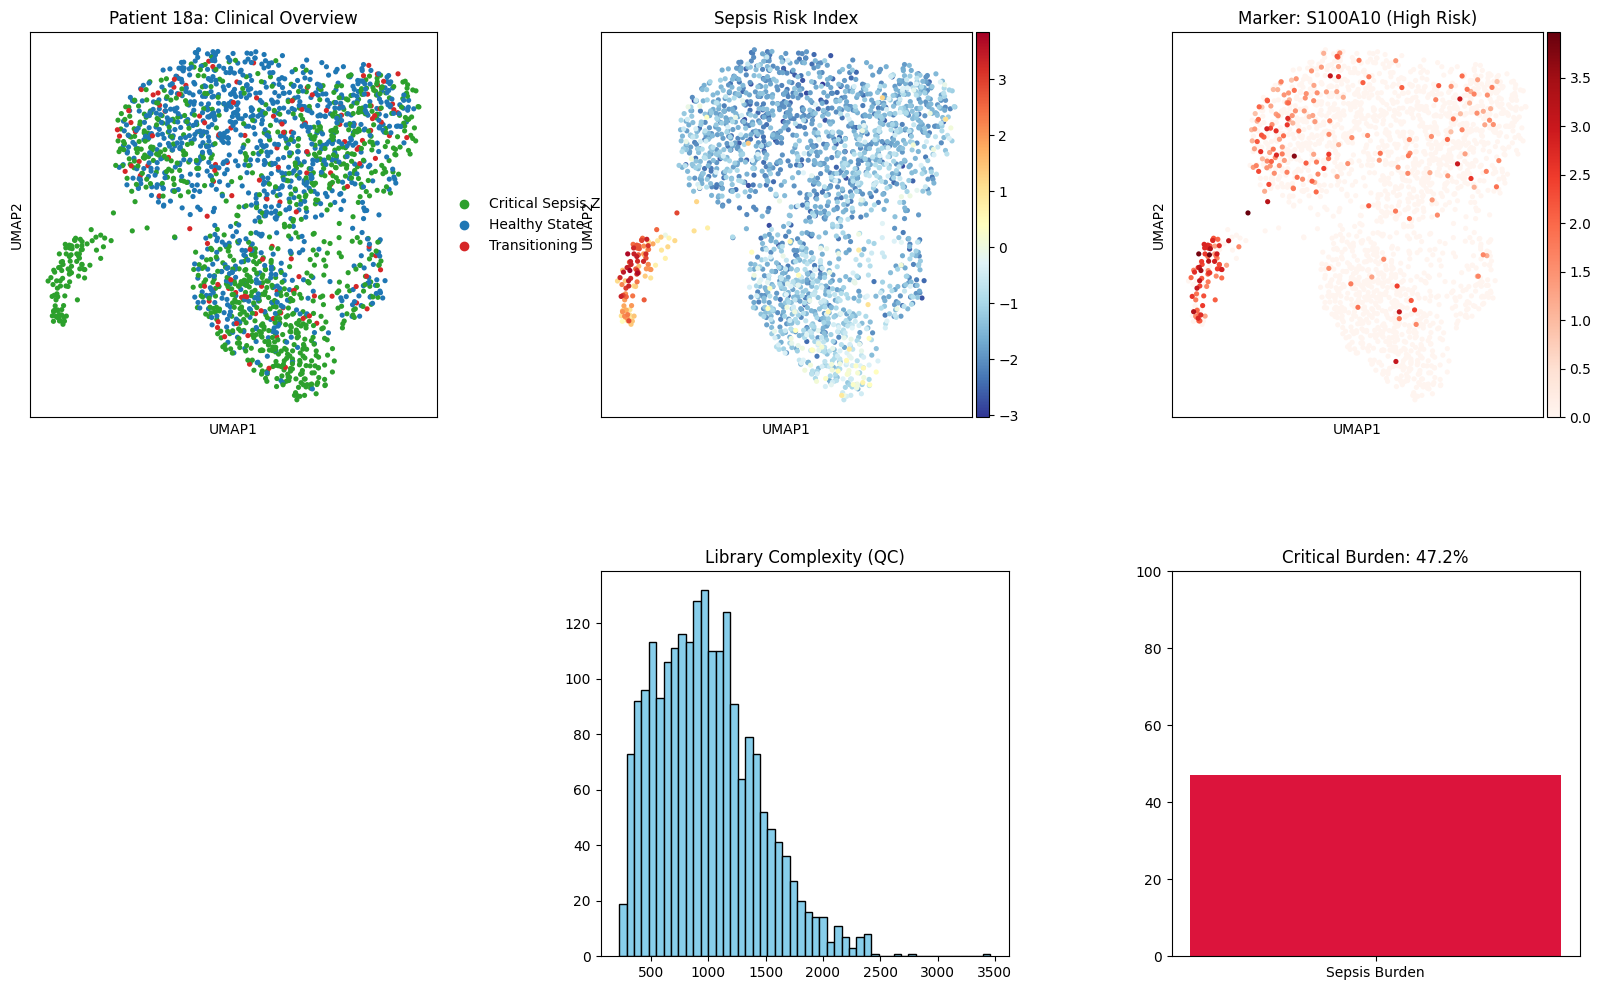

In [34]:
# --- 1. PATIENT ADMISSION ---
user_input = input("Enter Patient IDs to check (e.g., 18a, 19b, 39, 40): ")
patient_ids = [p.strip() for p in user_input.split(',')]

for p_id in patient_ids:
    print(f"\n" + "="*40)
    print(f"🩺 ANALYZING PATIENT CASE: {p_id}")
    print("="*40)

    m_search = glob.glob(f"**/*{p_id}*matrix.mtx.gz", recursive=True)
    if not m_search:
        print(f"❌ Error: Could not find data for '{p_id}'.")
        continue

    matrix_file = m_search[0]
    prefix = matrix_file.replace('matrix.mtx.gz', '')
    features_file = prefix + "features.tsv.gz"
    barcodes_file = prefix + "barcodes.tsv.gz"

    try:
        # --- 2. LOAD & QC ---
        print(f"📥 Loading {p_id}...")
        adata = sc.read_mtx(matrix_file).T
        genes = pd.read_csv(features_file, header=None, sep='\t')
        barcodes = pd.read_csv(barcodes_file, header=None, sep='\t')
        adata.var_names = genes[1].values if genes.shape[1] >= 2 else genes[0].values
        adata.obs_names = barcodes[0].values
        adata.var_names_make_unique()

        sc.pp.filter_cells(adata, min_genes=200)
        sc.pp.normalize_total(adata, target_sum=1e4)
        sc.pp.log1p(adata)
        adata.raw = adata

        # --- 3. SEPSIS SCORING (CRITICAL STEP) ---
        danger = ['S100A10', 'S100A11', 'S100A4', 'ANXA1', 'FXYD5']
        protective = ['HLA-DRA', 'HLA-DRB1', 'CD74', 'HLA-DPA1', 'HLA-DPB1', 'CD83']
        d_found = [g for g in danger if g in adata.var_names]
        p_found = [g for g in protective if g in adata.var_names]

        sc.tl.score_genes(adata, d_found, score_name='danger_score')
        sc.tl.score_genes(adata, p_found, score_name='protective_score')
        # This creates the column the error was complaining about:
        adata.obs['sepsis_risk_index'] = adata.obs['danger_score'] - adata.obs['protective_score']

        # --- 4. UMAP MATH ---
        sc.pp.highly_variable_genes(adata, n_top_genes=2000)
        sc.tl.pca(adata, svd_solver='arpack')
        sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
        sc.tl.umap(adata)

        # --- 5. MASTER DASHBOARD PLOTTING ---
       # --- 5. FINALIZED MASTER DASHBOARD (CLEAN LAYOUT) ---
        print(f"📊 Rendering Diagnostic Dashboard for {p_id}...")

        # Define Clinical States
        med_risk = adata.obs['sepsis_risk_index'].median()
        conditions = [
            (adata.obs['sepsis_risk_index'] < med_risk - 0.05),
            (adata.obs['sepsis_risk_index'] >= med_risk - 0.05) & (adata.obs['sepsis_risk_index'] <= med_risk + 0.05),
            (adata.obs['sepsis_risk_index'] > med_risk + 0.05)
        ]
        choices = ['Healthy State', 'Transitioning', 'Critical Sepsis Zone']
        adata.obs['Clinical State'] = np.select(conditions, choices, default='Transitioning')
        adata.obs['Clinical State'] = adata.obs['Clinical State'].astype('category')
        adata.uns['Clinical State_colors'] = ['#2ca02c', '#1f77b4', '#d62728']

        # Create the grid
        fig = plt.figure(figsize=(20, 12))
        gs = fig.add_gridspec(2, 3) # 2 rows, 3 columns
        plt.subplots_adjust(wspace=0.4, hspace=0.4)

        # 1. Top Left: Clinical State
        ax1 = fig.add_subplot(gs[0, 0])
        sc.pl.umap(adata, color='Clinical State', show=False, ax=ax1)
        ax1.set_title(f"Patient {p_id}: Clinical Overview")

        # 2. Top Middle: Risk Gradient
        ax2 = fig.add_subplot(gs[0, 1])
        sc.pl.umap(adata, color='sepsis_risk_index', cmap='RdYlBu_r', show=False, ax=ax2)
        ax2.set_title("Sepsis Risk Index")

        # 3. Top Right: Danger Marker
        ax3 = fig.add_subplot(gs[0, 2])
        sc.pl.umap(adata, color='S100A10', cmap='Reds', show=False, ax=ax3)
        ax3.set_title("Marker: S100A10 (High Risk)")

        # 4. Bottom Middle: Cell Health
        ax4 = fig.add_subplot(gs[1, 1])
        ax4.hist(adata.obs['n_genes'], bins=50, color='skyblue', edgecolor='black')
        ax4.set_title("Library Complexity (QC)")

        # 5. Bottom Right: Sepsis Burden
        ax5 = fig.add_subplot(gs[1, 2])
        high_risk_pct = (adata.obs['Clinical State'] == 'Critical Sepsis Zone').mean() * 100
        ax5.bar(['Sepsis Burden'], [high_risk_pct], color='crimson')
        ax5.set_ylim(0, 100)
        ax5.set_title(f"Critical Burden: {high_risk_pct:.1f}%")

        # NOTE: We skip gs[1, 0] entirely. By not creating an 'ax' for it,
        # the bottom-left space remains empty/transparent instead of showing a white box.

        plt.show()

    except Exception as e:
        print(f"❌ Error processing {p_id}: {e}")
    finally:
        if 'adata' in locals(): del adata
        plt.close('all')
        gc.collect()